[数据科学和人工智能技术笔记 十二、逻辑回归](https://github.com/apachecn/ds-ai-tech-notes/blob/master/12.md)
# Cs 超参数快速调优
---

有时，学习算法的特征使我们能够比蛮力或随机模型搜索方法更快地搜索最佳**超参数**(在开始学习过程之前设置值的参数)。
>超参数的一些示例：
 - 树的数量或树的深度
 - 矩阵分解中潜在因素的数量
 - 学习率（多种模式）
 - 深层神经网络隐藏层数
 - k均值聚类中的簇数

scikit-learn 的`LogisticRegressionCV`方法包含一个参数`Cs`。 如果提供了一个列表，`Cs`是inverse可供选择的候选超参数值。 如果提供了一个整数，`Cs`的这么多个候选值，将从 0.0001 和 10000 之间的对数标度（`Cs`的合理值范围）中提取。 Like in support vector machines, smaller values specify stronger regularization

LogisticRegressionCV通过内置的交叉验证支持实现Logistic回归，以根据评分属性找到最佳C和l1_ratio参数。

In [1]:
from sklearn import datasets, linear_model
import numpy as np
np.set_printoptions(threshold=15)

In [2]:
iris = datasets.load_iris()
X = iris.data[:100]
y = iris.target[:100]
X

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       ...,
       [6.2, 2.9, 4.3, 1.3],
       [5.1, 2.5, 3. , 1.1],
       [5.7, 2.8, 4.1, 1.3]])

'''
Cs [list of floats or int, optional (default=10)] Each of the values in Cs describes the inverse of
regularization strength. If Cs is as an int, then a grid of Cs values are chosen in a logarithmic scale between 1e-4 and 1e4. Like in support vector machines, smaller values specify
stronger regularization
'''

In [3]:
# 创建logistic回归的交叉验证
clf = linear_model.LogisticRegressionCV(Cs=100, multi_class='auto', cv=5)
clf
# . ‘auto’ selects ‘ovr’ if the data
# is binary, or if solver=’liblinear’, and otherwise selects ‘multinomial’.

LogisticRegressionCV(Cs=100, cv=5)

In [4]:
clf.fit(X, y)

LogisticRegressionCV(Cs=100, cv=5)

In [5]:
new_observation = [[5.0, 3.5, 1.3, 0.2], [6.2, 2.9, 4.3, 1.3]]
clf.predict(new_observation)

array([0, 1])

In [6]:
clf.Cs_

array([1.00000000e-04, 1.20450354e-04, 1.45082878e-04, ...,
       6.89261210e+03, 8.30217568e+03, 1.00000000e+04])

# 在逻辑回归中处理不平衡类别
---
像 scikit-learn 中的许多其他学习算法一样，`LogisticRegression`带有处理不平衡类的内置方法。 如果我们有高度不平衡的类，并且在预处理期间没有解决它，我们可以选择使用`class_weight`参数来对类加权，确保我们拥有每个类的平衡组合。 具体来说，`balanced`参数会自动对类加权，与其频率成反比：
$$w_j = \frac {n}{kn_j}$$
$w_j$是$j$类的权重, $n$是总观测数, $n_j$是类$j$的观测数, $k$为类的总数

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [8]:
# 通过移除前 40 个观测，使类高度不均衡
X = iris.data[40:, :]
y = iris.target[40:]
# 创建目标向量，如果表示类别是否为 0
y = np.where(y==0, 0, 1)  # 10 个label为0 其余100个设为1

In [9]:
scaler = StandardScaler()
# The standard score of a sample x is calculated as:z = (x - u) /s
# where u is the mean of the training samples or zero if with_mean=False, 
# and s is the standard deviation of the training sample
X_std = scaler.fit_transform(X)
X_std

array([[-1.51810416,  1.60348073, -2.61034098, -2.20112727],
       [-2.18607   , -1.67806123, -2.61034098, -2.20112727],
       [-2.31966316,  0.78309524, -2.61034098, -2.37721745],
       ...,
       [ 0.48579333,  0.23617158,  0.48056788,  0.79240582],
       [ 0.08501383,  1.3300189 ,  0.63907603,  1.32067636],
       [-0.31576567,  0.23617158,  0.40131381,  0.44022545]])

In [11]:
# 创建分类器对象
clf = LogisticRegression(random_state=0, class_weight='balanced')
model = clf.fit(X_std, y)

In [12]:
new_observation = [[5.0, 3.5, 1.3, 0.2], [6.2, 2.9, 4.3, 1.3]]
new_observation_std = scaler.transform(new_observation)
new_observation_std

array([[-1.51810416,  1.60348073, -2.61034098, -2.37721745],
       [ 0.08501383, -0.03729025, -0.23271878, -0.44022545]])

In [14]:
model.predict_proba(new_observation_std)

array([[0.99402689, 0.00597311],
       [0.01694628, 0.98305372]])

# 大量数据上的逻辑回归
---
scikit-learn 的`LogisticRegression`提供了许多用于训练逻辑回归的技术，称为求解器。 大多数情况下，scikit-learn 会自动为我们选择最佳求解器，或警告我们，你不能用求解器做一些事情。 但是，我们应该注意一个特殊情况。

虽然精确的解释超出了本书的范围，但随机平均梯度下降使得我们在数据非常大时，比其他求解器更快训练模型。 但是，对特征尺度也非常敏感，标准化我们的特征尤为重要。 我们可以通过设置`solver ='sag'`(Stochastic Average Gradient descent)来设置我们的学习算法来使用这个求解器。  



在 LogisticRegression 类中实现了这些优化算法: liblinear， newton-cg， lbfgs， sag 和 saga。

liblinear应用了坐标下降算法（Coordinate Descent, CD），并基于 scikit-learn 内附的高性能 C++ 库 LIBLINEAR library 实现。不过 CD 算法训练的模型不是真正意义上的多分类模型，而是基于 “one-vs-rest” 思想分解了这个优化问题，为每个类别都训练了一个二元分类器。因为实现在底层使用该求解器的 LogisticRegression 实例对象表面上看是一个多元分类器。 sklearn.svm.l1_min_c 可以计算使用 L1时 C 的下界，以避免模型为空（即全部特征分量的权重为零）。

lbfgs, sag 和 newton-cg 求解器只支持 L2罚项以及无罚项，对某些高维数据收敛更快。这些求解器的参数 multi_class设为 multinomial 即可训练一个真正的多项式 logistic 回归 [5] ，其预测的概率比默认的 “one-vs-rest” 设定更为准确。

sag 求解器基于平均随机梯度下降算法（Stochastic Average Gradient descent） [6]。在大数据集上的表现更快，大数据集指样本量大且特征数多。

saga 求解器 [7] 是 sag 的一类变体，它支持非平滑（non-smooth）的 L1 正则选项 penalty="l1" 。因此对于稀疏多项式 logistic 回归 ，往往选用该求解器。saga求解器是唯一支持弹性网络正则选项的求解器。

lbfgs是一种近似于Broyden–Fletcher–Goldfarb–Shanno算法[8]的优化算法，属于准牛顿法。lbfgs求解器推荐用于较小的数据集，对于较大的数据集，它的性能会受到影响。[9]

In [15]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_std

array([[-0.90068117,  1.01900435, -1.34022653, -1.3154443 ],
       [-1.14301691, -0.13197948, -1.34022653, -1.3154443 ],
       [-1.38535265,  0.32841405, -1.39706395, -1.3154443 ],
       ...,
       [ 0.79566902, -0.13197948,  0.8195957 ,  1.05393502],
       [ 0.4321654 ,  0.78880759,  0.93327055,  1.44883158],
       [ 0.06866179, -0.13197948,  0.76275827,  0.79067065]])

In [29]:
clf = LogisticRegression(random_state=0, solver='sag', multi_class='multinomial')  # 默认 multinomial
clf.fit(X_std, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=0, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
new_observation = [[5.0, 3.5, 1.3, 0.2], [6.2, 2.9, 4.3, 1.3]]
new_observation_std = scaler.transform(new_observation)
new_observation_std

array([[-1.02184904,  1.01900435, -1.39706395, -1.3154443 ],
       [ 0.4321654 , -0.36217625,  0.30805885,  0.13250973]])

In [31]:
clf.predict(new_observation_std)

array([0, 1])

In [32]:
model.predict_proba(new_observation_std)

array([[0.85462231, 0.14537769],
       [0.02387029, 0.97612971]])

# 带有 L1 正则化的逻辑回归
---
L1 正则化（也称为最小绝对误差）是数据科学中的强大工具。 有许多教程解释` L1 `正则化，我不会在这里尝试这样做。 相反，本教程将展示正则化参数`C`对系数和模型精度的影响。
> L1范数 $||w||_1$ 也叫曼哈顿距离(Manhattan distance) 绝对值的和

**C** [float, optional (default=1.0)] Inverse of regularization strength; must be a positive float. Like
in support vector machines, **smaller** values specify **stronger** regularization.

In [16]:
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X = iris.data
y = iris.target
# 取 0, 1 两类数据
X = X[y != 2]
y = y[y != 2]
X

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       ...,
       [6.2, 2.9, 4.3, 1.3],
       [5.1, 2.5, 3. , 1.1],
       [5.7, 2.8, 4.1, 1.3]])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

因为正则化惩罚由系数的绝对值之和组成，所以我们需要缩放数据，使系数都基于相同的比例。

In [18]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_train_std

array([[-0.80800774, -2.29964195,  0.43666598,  0.36280263],
       [ 0.01648995, -1.47624074,  0.64460217,  0.53674909],
       [ 0.01648995, -1.06454014,  1.06047453,  0.71069556],
       ...,
       [ 0.18138949, -0.44698923,  0.50597804,  0.88464203],
       [-1.4676059 ,  0.17056168, -1.01888729, -1.0287691 ],
       [-0.6431082 ,  1.4056635 , -0.67232699, -0.68087617]])

In [19]:
X_test_std = scaler.transform(X_test)

L1 的用处在于它可以将特征系数逼近 0，从而创建一种特征选择方法。 在下面的代码中，我们运行带有 L1 惩罚的逻辑回归四次，每次都减少了C的值。 我们应该期望随着C的减少，更多的系数变为 0。

In [20]:
C = [10, 1, 0.1, 0.001]
for c in C:
    clf = LogisticRegression(penalty='l1', C=c, solver='liblinear')
    clf.fit(X_train_std, y_train)
    print("C:", c)
    print('特征系数Coefficient:', clf.coef_)
    print('Training accuracy:', clf.score(X_train_std, y_train))
    print('Test accuracy:', clf.score(X_test_std, y_test))
    print()

C: 10
特征系数Coefficient: [[ 0.         -1.29862161  2.7511185   3.83972895]]
Training accuracy: 1.0
Test accuracy: 1.0

C: 1
特征系数Coefficient: [[ 0.         -0.66334853  2.25997717  1.77191759]]
Training accuracy: 1.0
Test accuracy: 1.0

C: 0.1
特征系数Coefficient: [[0.         0.         1.41157315 0.33758321]]
Training accuracy: 1.0
Test accuracy: 1.0

C: 0.001
特征系数Coefficient: [[0. 0. 0. 0.]]
Training accuracy: 0.5
Test accuracy: 0.5



注意，当C减小时，模型系数变小，直到C = 0.001，所有系数都是零。 这是变得更加突出的，正则化惩罚的效果。

# OVR 逻辑回归 和 多项式逻辑回归
---
逻辑回归本身只是二分类器，这意味着它们无法处理具有两个类别以上的目标向量。 但是，逻辑回归有一些聪明的扩展来实现它。 在 `One-VS-Rest（OVR）`逻辑回归中，针对每个类别训练单独的模型，预测观测是否是该类（因此使其成为二分类问题）。 它假定每个分类问题（例如是不是类 0）是独立的。

**multi_class** [str, {‘ovr’, ‘multinomial’, ‘auto’}, optional (default=’ovr’)] If the option chosen
is ‘ovr’, then a binary problem is fit for each label. For ‘multinomial’ the loss minimised
is the multinomial loss fit across the entire probability distribution, even when the data is
binary. ‘multinomial’ is unavailable when solver=’liblinear’. ‘auto’ selects ‘ovr’ if the data
is binary, or if solver=’liblinear’, and otherwise selects ‘multinomial’.
New in version 0.18: Stochastic Average Gradient descent solver for ‘multinomial’ case.
Changed in version 0.20: Default will change from ‘ovr’ to ‘auto’ in 0.22.

In [21]:
import matplotlib.pyplot as plt 
%matplotlib inline

In [22]:
# 3中类别数据的中心
centers = [[-5, 0], [0, 1.5], [5, -1]]
# 生成各向同性的高斯斑点以进行聚类。
X, y = datasets.make_blobs(n_samples=1000, centers=centers, random_state=40)
X

array([[-5.09227256,  0.87072588],
       [-4.76257213, -0.39181357],
       [-6.3026177 , -0.16682567],
       ...,
       [-5.2400059 , -0.5227223 ],
       [ 1.23443662,  3.65230326],
       [ 3.69532699,  0.66714967]])

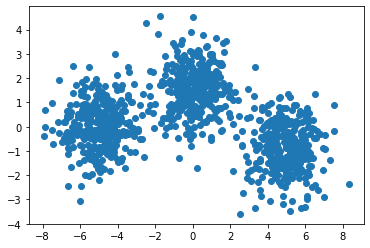

In [23]:
plt.scatter(X[:, 0], X[:, 1])

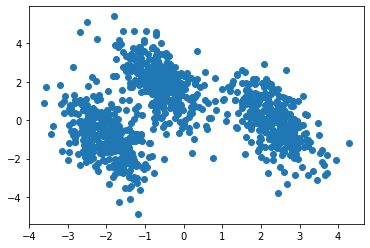

In [24]:
transformation = [[0.4, 0.2], [-0.4, 1.2]]
X = np.dot(X, transformation)  # (0.4x-0.4y, 0.2x+1.2y)
plt.scatter(X[:, 0], X[:, 1])

In [25]:
X

array([[-2.38519938,  0.02641654],
       [-1.74830343, -1.4226907 ],
       [-2.45431681, -1.46071435],
       ...,
       [-1.88691344, -1.67526794],
       [-0.96714666,  4.62965124],
       [ 1.21127093,  1.53964501]])

In [26]:
# Translates slice objects to concatenation along the second axis.
np.c_[np.array([1, 2, 3]), np.array([4,5,6])]

array([[1, 4],
       [2, 5],
       [3, 6]])

In [27]:
xx, yy = np.meshgrid(np.arange(0, 100, 0.5), np.arange(0, 100, .5))
xx.shape

(200, 200)

In [28]:
xx, yy = np.mgrid[0:100:0.5, 0:100:0.5]
xx.shape

(200, 200)

training score : 0.995 (multinomial)
training score : 0.976 (ovr)


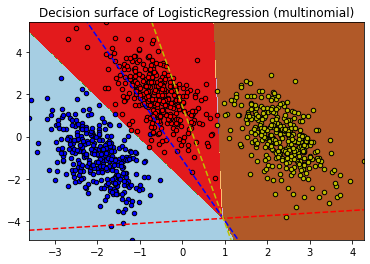

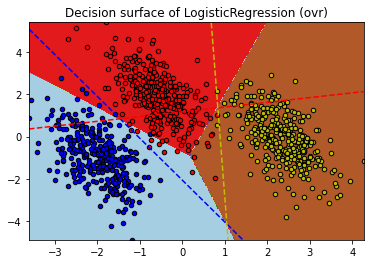

In [29]:
for multi_class in ('multinomial', 'ovr'):
    clf = LogisticRegression(solver='sag', max_iter=100, random_state=42,
                             multi_class=multi_class).fit(X, y)
    print("training score : %.3f (%s)" % (clf.score(X, y), multi_class))
    # create a mesh to plot in
    h = .02 # step size in the mesh
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    # 生成平面网格 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # 画出决策边界, 颜色区分
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])  # 判断点 (xx[i], yy[i])
    # 从一维矩阵 转成二维矩阵
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.title(f'Decision surface of LogisticRegression ({multi_class})')
    plt.axis('tight')
    
    # 画出测试点
    colors = 'bry'
    for i, color in zip(clf.classes_, colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired,
                    edgecolor='black', s=20)
    
    # 根据系数画出分类超平面
    # Plot the three one-against-all classifiers
    xmin, xmax = plt.xlim()  # 只需要取2点确定
    ymin, ymax = plt.ylim()
    coef = clf.coef_  # [ 超平面1系数, 超平面2系数]
    intercept = clf.intercept_
    def plot_hyperplane(c, color):
        def line(x):  
            # w0 + w1x1 + w2x2 = 0 -> x2 = -(w0 + w1x1)/w2
            return -(x * coef[c, 0] + intercept[c]) / coef[c, 1]
        plt.plot([xmin, xmax], [line(xmin), line(xmax)], ls='--', color=color)
    
    for i, color in zip(clf.classes_, colors):
        plot_hyperplane(i, color)
    

[One vs One 和 One vs Rest 的区别](https://stackoverflow.com/questions/50522462/what-is-the-difference-between-one-vs-rest-and-one-vs-one-strategies-in-mult)